## Sample Analysis

In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('/srv/scratch/z5297792/Sample/sample_data.pkl', 'rb') as file:
    sample_data = pickle.load(file)
print(sample_data.keys())

the_chosen_eddies = ['Eddy22', 'Eddy110', 'Eddy134', 'Eddy133']

dict_keys(['Eddy8', 'Eddy9', 'Eddy22', 'Eddy32', 'Eddy60', 'Eddy110', 'Eddy117', 'Eddy124', 'Eddy133', 'Eddy134', 'Eddy141', 'Eddy142', 'Eddy149', 'Eddy151', 'Eddy161', 'Eddy171'])


In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

In [9]:
# eddy = 'Eddy133' # CE tilt
# eddy = 'Eddy134' # CE non-tilt # good
# eddy = 'Eddy22' # AE no-tilt # good
# eddy = 'Eddy110' # AE tilt 


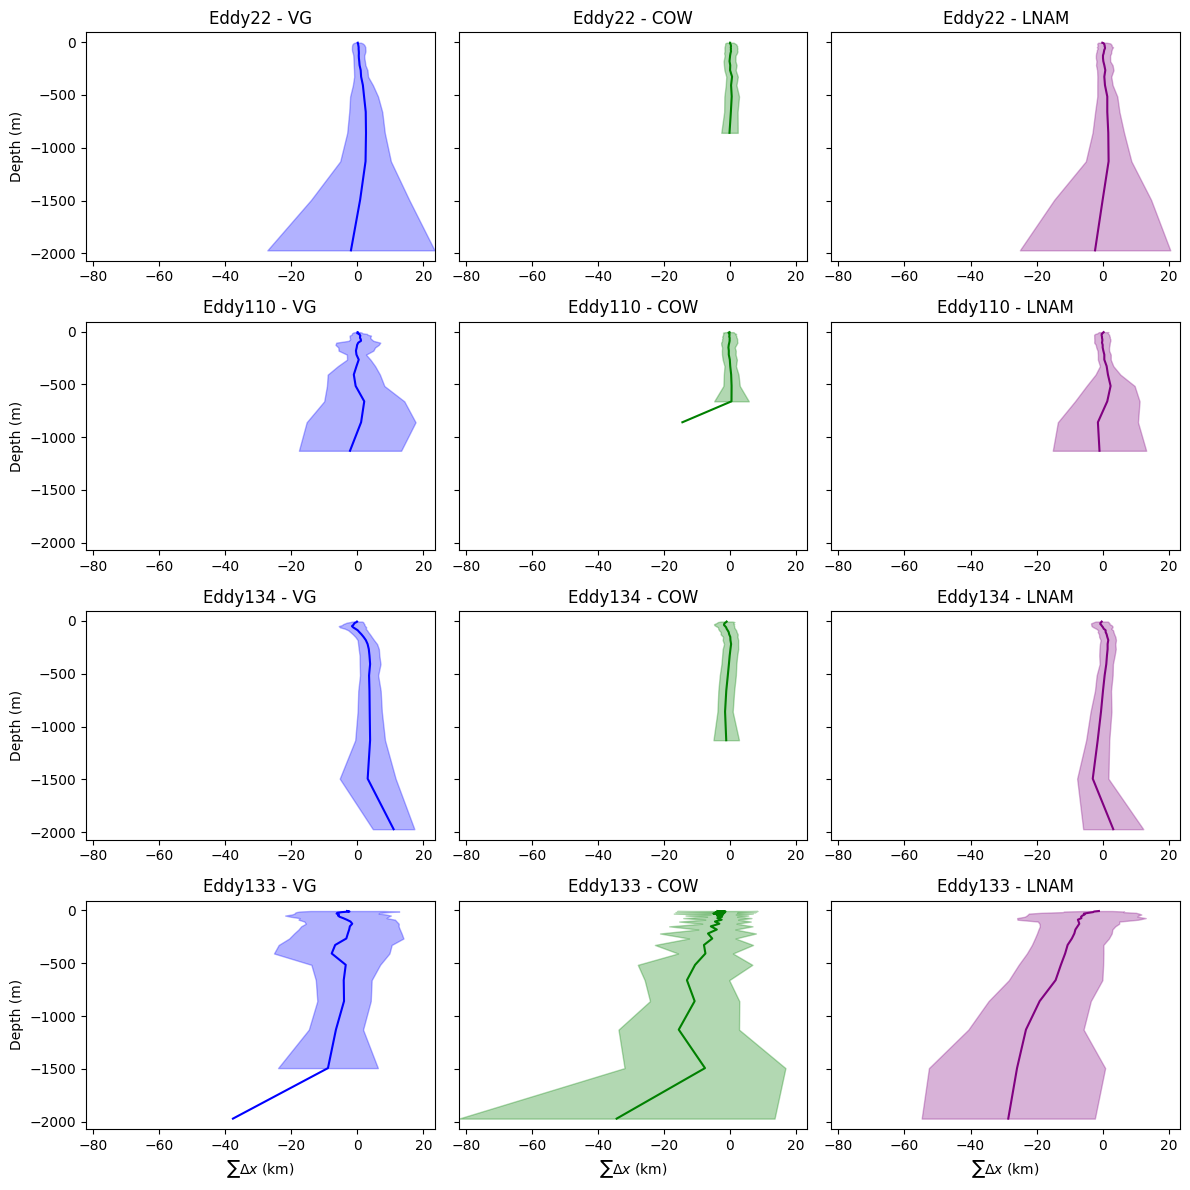

In [16]:
eddies = ['Eddy22', 'Eddy110', 'Eddy134', 'Eddy133']

DEPTH_LVL_LIMIT = 25

method_colors = {'VG': 'blue', 'COW': 'green', 'LNAM': 'purple'}

# fig, axes = plt.subplots(4, 3, figsize=(12, 12), sharex=True, sharey=True)
fig, axes = plt.subplots(4, 3, figsize=(12, 12), sharey=True)

xmin = xmax = 0
for i, eddy in enumerate(eddies):
    for j, (method, color) in enumerate(method_colors.items()):
        ax = axes[i, j]
        x_df = pd.DataFrame({f'T{t}': sample_data[eddy][f'T{t}'][method]['x'] for t in range(30)})
        x_mean, x_std = x_df.iloc[:DEPTH_LVL_LIMIT].diff().cumsum().mean(axis=1)/1000, x_df.iloc[:DEPTH_LVL_LIMIT].diff().cumsum().std(axis=1)/1000
        ax.plot(x_mean, z_r[150, 150, :len(x_mean)], color=color)
        ax.fill_betweenx(z_r[150, 150, :len(x_mean)], x_mean - x_std, x_mean + x_std, color=color, alpha=0.3)
        ax.set_title(eddy + ' - ' + method)
        if j == 0: ax.set_ylabel("Depth (m)")
        if i == 3: ax.set_xlabel(r"$\sum\Delta x$ (km)")

        xmin = min(np.nanmin(x_mean - x_std), xmin)
        xmax = max(np.nanmax(x_mean + x_std), xmax)

# Set common x-axis limits
x_lim = [xmin, xmax]
for ax in axes.flat:
    ax.set_xlim(x_lim)

plt.tight_layout()
plt.show()


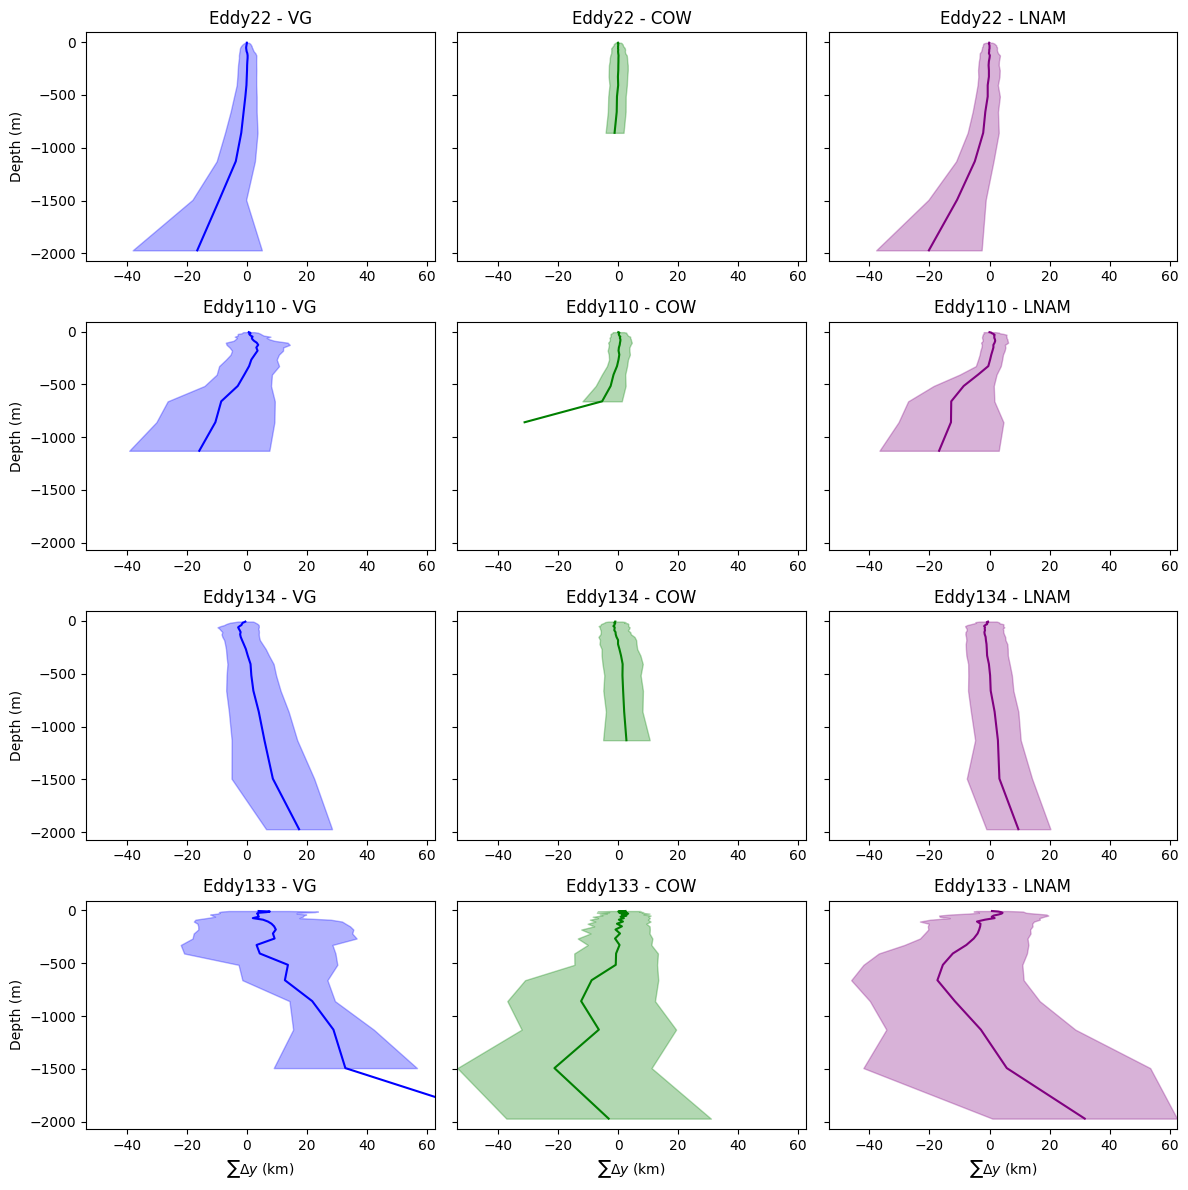

In [18]:
eddies = ['Eddy22', 'Eddy110', 'Eddy134', 'Eddy133']

DEPTH_LVL_LIMIT = 25

method_colors = {'VG': 'blue', 'COW': 'green', 'LNAM': 'purple'}

# fig, axes = plt.subplots(4, 3, figsize=(12, 12), sharex=True, sharey=True)
fig, axes = plt.subplots(4, 3, figsize=(12, 12), sharey=True)

xmin = xmax = 0
for i, eddy in enumerate(eddies):
    for j, (method, color) in enumerate(method_colors.items()):
        ax = axes[i, j]
        y_df = pd.DataFrame({f'T{t}': sample_data[eddy][f'T{t}'][method]['y'] for t in range(30)})
        y_mean, y_std = y_df.iloc[:DEPTH_LVL_LIMIT].diff().cumsum().mean(axis=1)/1000, y_df.iloc[:DEPTH_LVL_LIMIT].diff().cumsum().std(axis=1)/1000
        ax.plot(y_mean, z_r[150, 150, :len(y_mean)], color=color)
        ax.fill_betweenx(z_r[150, 150, :len(y_mean)], y_mean - y_std, y_mean + y_std, color=color, alpha=0.3)
        ax.set_title(eddy + ' - ' + method)
        if j == 0: ax.set_ylabel("Depth (m)")
        if i == 3: ax.set_xlabel(r"$\sum\Delta y$ (km)")

        xmin = min(np.nanmin(y_mean - y_std), xmin)
        xmax = max(np.nanmax(y_mean + y_std), xmax)

# Set common x-axis limits
x_lim = [xmin, xmax]
for ax in axes.flat:
    ax.set_xlim(x_lim)

plt.tight_layout()
plt.show()